In [1]:
import numpy
import os
import cv2
import time
import matplotlib.pyplot
from PIL import Image
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [7]:
width = 160
height = 60
TRAIN_DATA = 'lane_data'
VAL_DATA = 'lane_data/val'

Xtrain =[]
Ytrain = []
# one-host encoding
dict = {'right': [1, 0], 'wrong': [0, 1]}

In [21]:
def rotate_image(image, label):
    list_image = []
    list_label = []
    count = 0
    center = (width // 2, height // 2)
    for distance in range (-8, 10, 2):
        translated_image = cv2.warpAffine(image, numpy.float32([[1, 0, distance], [0, 1, 0]]) , (width, height))
        for degrees in range(-15, 20, 5):
            distance_rotated_image = cv2.warpAffine(translated_image, cv2.getRotationMatrix2D(center, degrees, 1.0), (width, height))
            list_image.append(distance_rotated_image)
            list_label.append(label)
            count = count + 1
    return list_image, list_label

In [22]:
def ReadData(file):
    Data = []
    Label = []
    label = ''
    for folderName in os.listdir(file):
        filename_path = os.path.join(file, folderName)
        list_filename_sub_path = []
        label = folderName
        for filename_sub in os.listdir(filename_path):
            if (".jpg" in filename_sub or ".png" in filename_sub):
                filename_sub_path = os.path.join(filename_path, filename_sub)
                img = numpy.array(Image.open(filename_sub_path))
                img = cv2.resize(img, (width, height))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                list_rotate_image, list_label = rotate_image(img, dict[(label)])
                list_filename_sub_path.extend(list_rotate_image)
                Label.extend(list_label)
        Data.extend(list_filename_sub_path)
    return Data, Label


In [26]:
# Đọc dữ liệu từ TRAIN_DATA
Xtrain, Ytrain = ReadData(TRAIN_DATA)

print(len(Xtrain))
# # Chia dữ liệu thành tập huấn luyện và tập validation
# Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.3, random_state=42)

# Chia dữ liệu thành 80% train và 20% test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

# Chia tiếp dữ liệu train thành 80% train và 20% validate
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

# Đường dẫn tới thư mục lưu dữ liệu
base_dir = 'train_data'
os.makedirs(base_dir, exist_ok=True)

# Hàm lưu dữ liệu vào thư mục tương ứng
def save_data(X, Y, folder_name):
    folder_path = os.path.join(base_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    np.save(os.path.join(folder_path, 'X.npy'), X)
    np.save(os.path.join(folder_path, 'Y.npy'), Y)

# Lưu dữ liệu vào các thư mục tương ứng
save_data(Xtrain, Ytrain, 'train')
save_data(Xval, Yval, 'val')
save_data(Xtest, Ytest, 'test')


89838


In [34]:
base_dir = 'train_data'

def load_data(folder_name):
    folder_path = os.path.join(base_dir, folder_name)
    X = numpy.load(os.path.join(folder_path, 'X.npy'))
    Y = numpy.load(os.path.join(folder_path, 'Y.npy'))
    return X, Y

# Đọc dữ liệu từ các thư mục train, val, test
Xtrain, Ytrain = load_data('train')
Xval, Yval = load_data('val')
Xtest, Ytest = load_data('test')

# In thông tin về dữ liệu
print(f'Train data shape: X={Xtrain.shape}, Y={Ytrain.shape}')
print(f'Validation data shape: X={Xval.shape}, Y={Yval.shape}')
print(f'Test data shape: X={Xtest.shape}, Y={Ytest.shape}')

Train data shape: X=(57496, 60, 160), Y=(57496, 2)
Validation data shape: X=(14374, 60, 160), Y=(14374, 2)
Test data shape: X=(17968, 60, 160), Y=(17968, 2)


In [35]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.regularizers import l2

# model = models.Sequential([
#     layers.Conv2D(4, (3, 3), input_shape=(height, width, 1), activation = 'relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.15),
    
#     layers.Conv2D(8, (3, 3), activation = 'relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),

#     layers.Conv2D(16, (3, 3), activation = 'relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),

#     layers.Flatten(),
#     layers.Dense(2000, activation = 'relu'),
#     layers.Dense(1000, activation = 'relu'),
#     layers.Dense(500, activation = 'relu'),
#     layers.Dense(100, activation = 'relu'),
#     layers.Dense(2, activation = 'softmax'),
# ])

# model.summary()
# adam = Adam(learning_rate=0.001)
# # model.compile(optimizer='SGD',
# #                              loss='mse',
# #                              metrics=['accuracy'])

# # Compile the model with MeanSquaredError loss function
# model.compile(optimizer=adam,
#               loss=CategoricalCrossentropy(), #MSE
#               metrics=['accuracy'])

# early_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta= 0 , patience=10, verbose=1, mode="auto")

# # history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain), validation_data = (numpy.array(Xval), numpy.array(Yval)), epochs=300, batch_size=1200,
# #                          callbacks = [early_callback],
# #                          verbose=True)

# from tensorflow.keras.callbacks import CSVLogger

# # Định nghĩa callback CSVLogger để lưu loss và accuracy vào file CSV
# csv_logger = CSVLogger('training_log.csv', separator=',', append=False)

# # Huấn luyện mô hình với callback CSVLogger
# history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain),
#                     validation_data=(numpy.array(Xval), numpy.array(Yval)),
#                     epochs=90, batch_size=1200,
#                     callbacks=[early_callback, csv_logger],
#                     verbose=True)

# V3
# model = models.Sequential([
#     layers.Conv2D(4, (3, 3), input_shape=(height, width, 1), activation='relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.15),
    
#     layers.Conv2D(8, (3, 3), activation='relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),

#     layers.Conv2D(16, (3, 3), activation='relu'),
#     layers.MaxPool2D((2, 2)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),

#     layers.Flatten(),
#     layers.Dense(2000, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dense(1000, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dense(500, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dense(2, activation='softmax'),
# ])

# model.summary()

# adam = optimizers.Adam(learning_rate=0.001)

# model.compile(optimizer=adam,
#               loss=CategoricalCrossentropy(),
#               metrics=['accuracy'])

# early_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10, verbose=1, mode="auto")

# csv_logger = callbacks.CSVLogger('training_log_v3.csv', separator=',', append=False)

# history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain),
#                     validation_data=(numpy.array(Xval), numpy.array(Yval)),
#                     epochs=90, batch_size=1200,
#                     callbacks=[early_callback, csv_logger],
#                     verbose=True)

# model.save('model_trained_v3.h5')

# V4
model = models.Sequential([
    layers.Conv2D(4, (3, 3), input_shape=(height, width, 1), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(2000, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(1000, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(500, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(100, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(2, activation='softmax'),
])

model.summary()

adam = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

early_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10, verbose=1, mode="auto")

csv_logger = callbacks.CSVLogger('training_log_v4.csv', separator=',', append=False)

history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain),
                    validation_data=(numpy.array(Xval), numpy.array(Yval)),
                    epochs=90, batch_size=1200,
                    callbacks=[early_callback, csv_logger],
                    verbose=True)

model.save('model_trained_v4.h5')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 58, 158, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 29, 79, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 77, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 38, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 36, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 5, 18, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2000)           │     2,882,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,435,418 (20.73 MB)

 Trainable params: 5,435,362 (20.73 MB)

 Non-trainable params: 56 (224.00 B)

Epoch 1/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5590 - loss: 27.1879 - val_accuracy: 0.6378 - val_loss: 5.4082
Epoch 2/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6410 - loss: 4.0335 - val_accuracy: 0.6639 - val_loss: 1.9202
Epoch 3/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6605 - loss: 1.6834 - val_accuracy: 0.6636 - val_loss: 1.2260
Epoch 4/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6636 - loss: 1.1391 - val_accuracy: 0.6757 - val_loss: 0.9573
Epoch 5/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6751 - loss: 0.9212 - val_accuracy: 0.6919 - val_loss: 0.8375
Epoch 6/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6818 - loss: 0.8115 - val_accuracy: 0.6966 - val_loss: 0.7560
Epoch 7/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6906 - loss: 0.7427 - val_accuracy: 0.7088 - val_loss: 0.7091
Epoch 8/90
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7006 - loss: 0.7039 - val_accuracy: 0.7041 - val_los

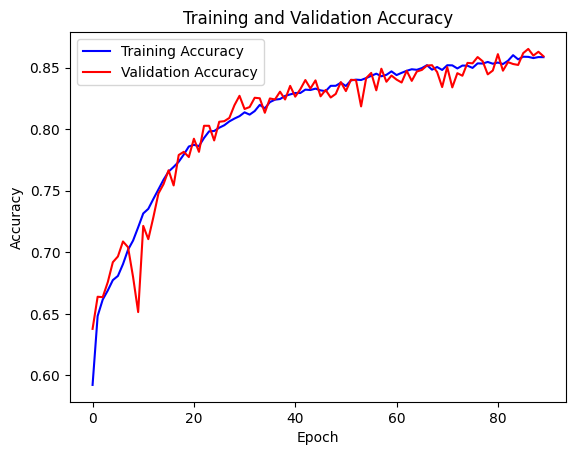

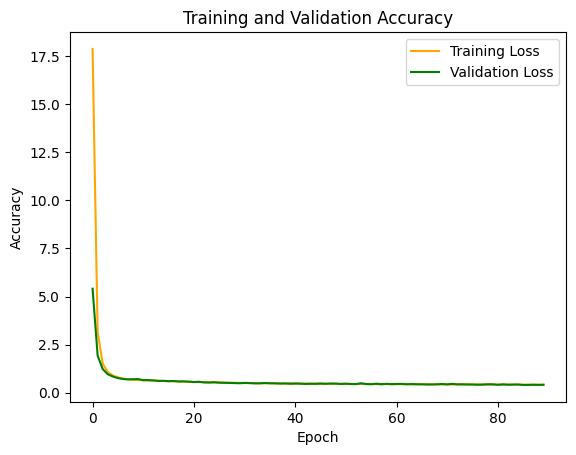

In [36]:

# print(history.history.keys())
# matplotlib.pyplot.plot(history.history['loss'], color='red')
# # matplotlib.pyplot.plot(history.history)
# # matplotlib.pyplot.title('model m')
# matplotlib.pyplot.ylabel('loss')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()
# # summarize history for loss mse
# matplotlib.pyplot.plot(history.history['accuracy'], color='blue')
# matplotlib.pyplot.ylabel('accuracy')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()

import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
log_data = pd.read_csv('training_log_v4.csv')

# Accuracy
plt.plot(log_data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(log_data['loss'], label='Training Loss', color='orange')
plt.plot(log_data['val_loss'], label='Validation Loss', color='green')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [38]:
dict = {'true': [1, 0], 'false': [0, 1]}
name_result = ['right', 'wrong']

# load model
modelTrained = keras.models.load_model('./model_trained_v4.h5')

# modelTrained.summary()

# dự đoán
# predict = modelTrained.predict(numpy.array(Xval))

img = numpy.array(Image.open('lane_data/wrong/result_b1w20.jpg'))

def result(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = name_result[numpy.argmax(modelTrained.predict(image.reshape(-1, height, width, 1)))]
    return result

# print(result(img))

test_idx = 22

result = name_result[numpy.argmax(modelTrained.predict(Xtest[test_idx].reshape(-1, height, width, 1)))]
print('prediction: ', result)
actual_label = name_result[numpy.argmax(Ytest[test_idx])]
print('expected: ', actual_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
prediction:  wrong
expected:  wrong
